In [1]:
import numpy as np

import random
import h5py
import theano.tensor as T
import theano
import scipy.io.wavfile as sciwav

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re


# for reproducibility
np.random.seed(1337) 
random.seed(1337)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 Ti (CNMeM is disabled, cuDNN 5105)


# Activation Functions and Derivatives

In [3]:
matplotlib.matplotlib_fname()

u'/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [4]:
def activation_plot(fnc, xscl = 4.0, fnc_yscl = None, grd_yscl = None):
    plt.close('all')
    
    grd = T.grad(fnc, x)
    function = theano.function([x], fnc)
    gradient = theano.function([x], grd)
    
    x_vals = np.arange(-xscl, xscl, 0.001)
    
    plt.figure(figsize = (10, 4))

    plt.subplot(121)
    plt.title('function')
    plt.grid()
    plt.axhline(0, color='gray', linewidth = 2)
    plt.axvline(0, color='gray', linewidth = 2)
    plt.xlim(-xscl, xscl)
    if (fnc_yscl):
        plt.ylim(fnc_yscl[0], fnc_yscl[1])
    plt.plot(x_vals, [function(i) for i in x_vals], '.', ms = 3)

    plt.subplot(122)
    plt.title('derivative')
    plt.grid()
    plt.axhline(0, color='gray', linewidth = 2)
    plt.axvline(0, color='gray', linewidth = 2)
    plt.xlim(-xscl, xscl)
    if (grd_yscl):
        plt.ylim(grd_yscl[0], grd_yscl[1])
    plt.plot(x_vals, [gradient(i) for i in x_vals], '.', ms = 3)

    plt.show()
    
x = T.dscalar()

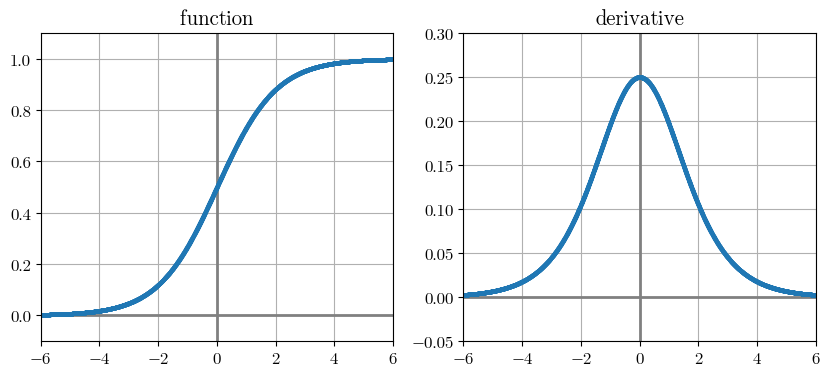

In [5]:
# sigmoid
fnc = 1 / (1 + T.exp(-x))
activation_plot(fnc, 6.0, (-0.1, 1.1), (-0.05, 0.3))

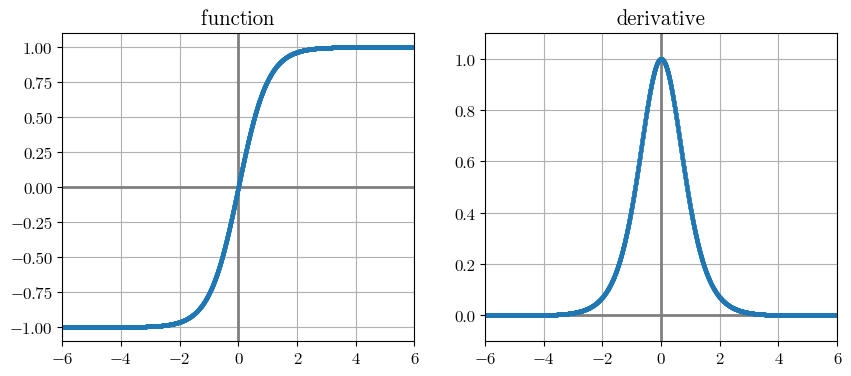

In [6]:
# tanh
fnc = T.tanh(x)
activation_plot(fnc, 6.0, (-1.1, 1.1), (-0.1, 1.1))

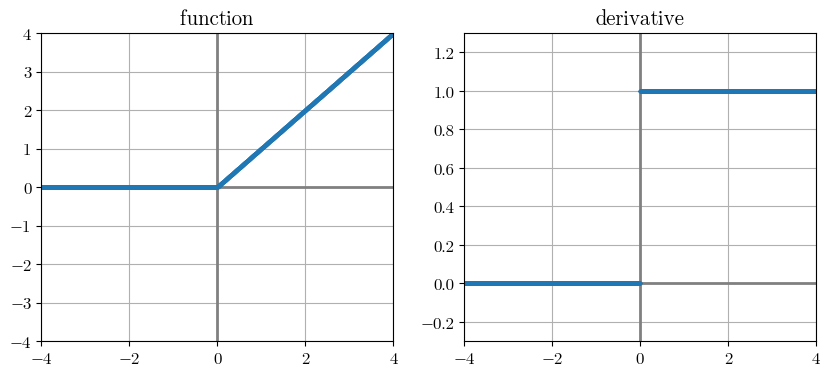

In [7]:
# ReLU
fnc = T.switch(x < 0, 0, x)
activation_plot(fnc, 4.0, (-4.0, 4.0), (-0.3, 1.3))

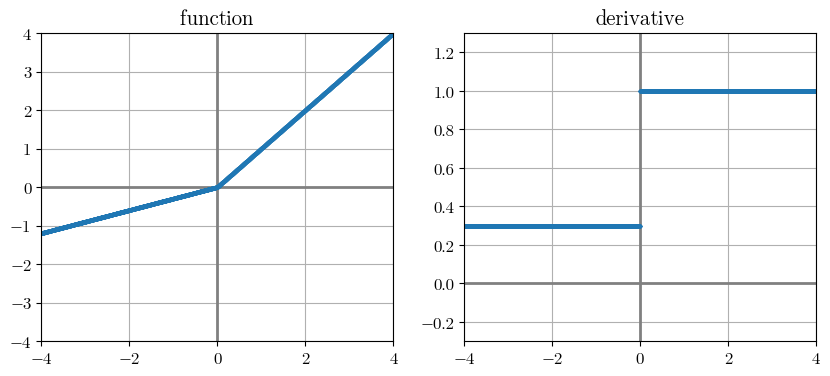

In [8]:
# Leaky ReLU
fnc = T.switch(x < 0, 0.3 * x, x)
activation_plot(fnc, 4.0, (-4.0, 4.0), (-0.3, 1.3))

# Visualizing Softmax

TO QUANTIZE: [ 0.515]


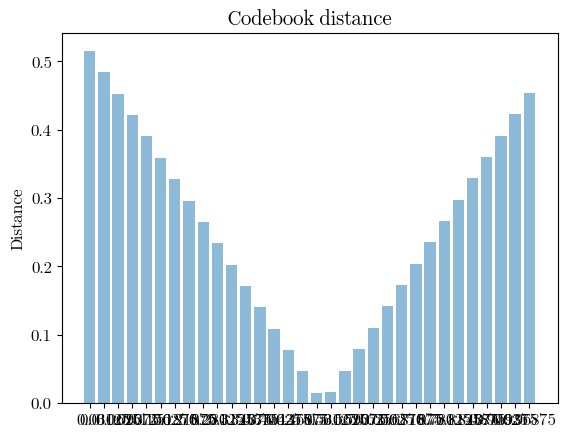

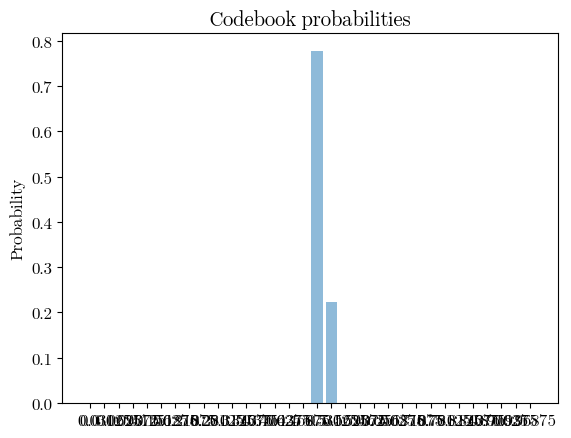

PROBS [  5.53793225e-218   2.06561890e-204   7.70464721e-191   2.87379190e-177
   1.07190890e-163   3.99816245e-150   1.49129306e-136   5.56244276e-123
   2.07476118e-109   7.73874745e-096   2.88651111e-082   1.07665309e-068
   4.01585804e-055   1.49789342e-041   5.58706175e-028   2.08394393e-014
   7.77299861e-001   2.22700139e-001   5.97059934e-015   1.60071999e-028
   4.29153649e-042   1.15056259e-055   3.08466276e-069   8.26999279e-083
   2.21718827e-096   5.94429032e-110   1.59366653e-123   4.27262614e-137
   1.14549272e-150   3.07107041e-164   8.23355166e-178   2.20741838e-191]
QUANTIZED: 0.506959379338


In [17]:
def numpy_softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

codebook = np.arange(0, 1, 1.0 / 32.0)
to_quantize = np.array([0.515]).astype('float')

distances = np.abs(codebook - to_quantize)

print "TO QUANTIZE:", to_quantize

labels = tuple([str(i) for i in codebook])
y_pos = np.arange(len(labels))

plt.bar(y_pos, distances, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Distance')
plt.title('Codebook distance')
plt.show()

SOFTMAX_TEMP = 1000.0
probs = numpy_softmax(SOFTMAX_TEMP * -distances)
plt.bar(y_pos, probs, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Probability')
plt.title('Codebook probabilities')
plt.show()
print "PROBS", probs

print "QUANTIZED:", np.dot(codebook, probs)